# Style Transfer by Gatys

В этом ноутбуке мы рассмотрим классический метод переноса стиля.

Здесь (как и в ноутбуке с Adversarial Attack) мы будем оптимизировать само изображение, но функция потерь в этом случае будет более интересная.

In [1]:
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

%matplotlib inline
%env CUDA_VISIBLE_DEVICES=0

import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as ts

from PIL import Image
import numpy as np
import os

env: CUDA_VISIBLE_DEVICES=0


In [2]:
# функции перевода из PIL.Image в torch.Tensor и обратно
to_image = ts.ToPILImage()
to_tensor = ts.Compose([
    ts.ToTensor()
])

# определяем функции загрузки и нормализации 
# изображения, а так же загружем предобученную VGG

def load_image(filepath, size=None, factor=None):
    image = Image.open(filepath).convert("RGB")
    if size:
        image = image.resize((size, size), Image.BICUBIC)
    elif factor:
        new_width = int(image.width * factor)
        new_height = int(image.height * factor)
        image = image.resize((new_width, new_height), Image.BICUBIC)
    return to_tensor(image)

mean = th.tensor([[[0.485]], [[0.456]], [[0.406]]]).cuda()
std = th.tensor([[[0.229]], [[0.224]], [[0.225]]]).cuda()

def normalize(x):
    return (x - mean) / std

model = tv.models.vgg19(pretrained=True)
model = model.eval().cuda()

In [5]:
def calc_losses(x_o, x_s, x_c):
    """Вычисление функции потерь для задачи Style Transfer.
    
    Внимание: неэффективная реализация, так как тензора x_s
    и x_c не меняются в процессе оптимизации и результаты 
    работы с ними можно было бы закешировать. Но для наглядности
    оставим как есть.
    
    Args:
        x_o (torch.FloatTensor): [3 x H x W] изображение, которое мы оптимизируем
        x_s (torch.FloatTensor): [3 x H' x W'] изображение-стиль
        x_c (torch.FloatTensor): [3 x H x W] изображение-контент
        
    Returns:
        torch.FloatTensor: значение функции потерь (скаляр)
    """
    
    def gram_matrix(x):
        """Вычисление матрицы Грама для данной feature-map.
        
        Args:
            x (torch.FloatTensor): [C x H x W] - произвольный тензор
            
        Returns:
            torch.FloatTensor: [C x C] матрица Грама
        """
        
        # сделаем flatten по пространственным координатам
        x = x.view(x.shape[0], -1)
        
        # умножим каждую строку полученной матрицы на все остальные
        g = th.mm(x, x.transpose(0, 1))
        
        # пронормируем на количество элементов,
        # чтобы быть инвариантным к W и H
        return g / x.numel()

    # производим нормализацию изображений
    x_s = normalize(x_s)
    x_c = normalize(x_c)
    x_o = normalize(x_o)

    style_losses = []
    content_losses = []
    
    idx = 0
    for layer in model.features:
        # вычисляем результат применения слоя к тензорам
        x_s = layer(x_s.unsqueeze(0)).squeeze(0)
        x_c = layer(x_c.unsqueeze(0)).squeeze(0)
        x_o = layer(x_o.unsqueeze(0)).squeeze(0)
        
        if isinstance(layer, nn.ReLU):
            # будем брать активации после ReLU,
            # но но все, а только те, что нам интересны
            
            # если это 0-ая, 2-ая, 4-ая, 8-ая или 12-ая
            # активация, то посчитаем Style Loss
            if idx in [0, 2, 4, 8, 12]:
                # вычисляем матрицы Грама для карт признаков
                # изображения стиля и оптимизируемого изображения
                g_s = gram_matrix(x_s)
                g_o = gram_matrix(x_o)
                
                # считаем MSE для полученных матриц Грама
                loss = F.mse_loss(g_o, g_s.detach())
                style_losses.append(loss)
            
            # если это 9-ая активация, то 
            # посчитаем Content Loss
            if idx in [9]:
                # просто считаем MSE между картами признаков
                # изображений контента и оптимизируемого изображения
                loss = F.mse_loss(x_o, x_c.detach())
                content_losses.append(loss)
            
            idx += 1
    
    # суммируем loss-ы со специально подобранным коэффициентом
    return sum(style_losses) * 1000000 + sum(content_losses)

In [6]:
def make_style_transfer(x_s, x_c):
    """Функция переноса стиля.
    
    Внимание: ограничения на размеры изображений нет.
    
    Args:
        x_s (torch.FloatTensor): изображение стиля
        x_c (torch.FloatTensor): изображение контента
        
    Returns:
        torch.FloatTensor: полученное изображение
    """
    x_s = x_s.cuda()
    x_c = x_c.cuda()

    # инициализируем оптимизируемое изображение
    # из изображения контента, помечаем его как "оптимизируемое"
    x_o = x_c.clone().requires_grad_()

    # кладём в оптимизатор (здесь лучше использовать L-BFGS)
    optimizer = optim.LBFGS([x_o])

    for t in tqdm(range(15)):

        # L-BFGS требует определить функции, которая
        # возращает функцию потерь и считает градиенты
        def closure():
            optimizer.zero_grad()
            loss = calc_losses(x_o, x_s, x_c)
            loss.backward()
            return loss

        loss = optimizer.step(closure)

        # не забываем клипать изображение!
        x_o.data.clamp_(0, 1)
    
    # "вырываем" тензор из графа
    return x_o.detach().cpu()

In [39]:
STYLE_FILENAMES = [
    "la_muse.jpg", "rain_princess.jpg", "the_scream.jpg",
    "udnie.jpg", "puantilism.jpg", "sea.png",
    "the_shipwreck_of_the_minotaur.jpg", "wave.jpg"]
CONTENT_FILENAMES = [
    "bear.jpg", "bus.jpg", "giraffes.jpg", 
    "girl.jpg", "train.jpg", "woman.jpg", "alyona.jpg", "alyona2.jpg"]

# выбираем прозвольные изображения стиля и контента
style_path = os.path.join('./data/style-transfer/styles', STYLE_FILENAMES[1])
image_path = os.path.join('./data/style-transfer/contents', CONTENT_FILENAMES[-1])

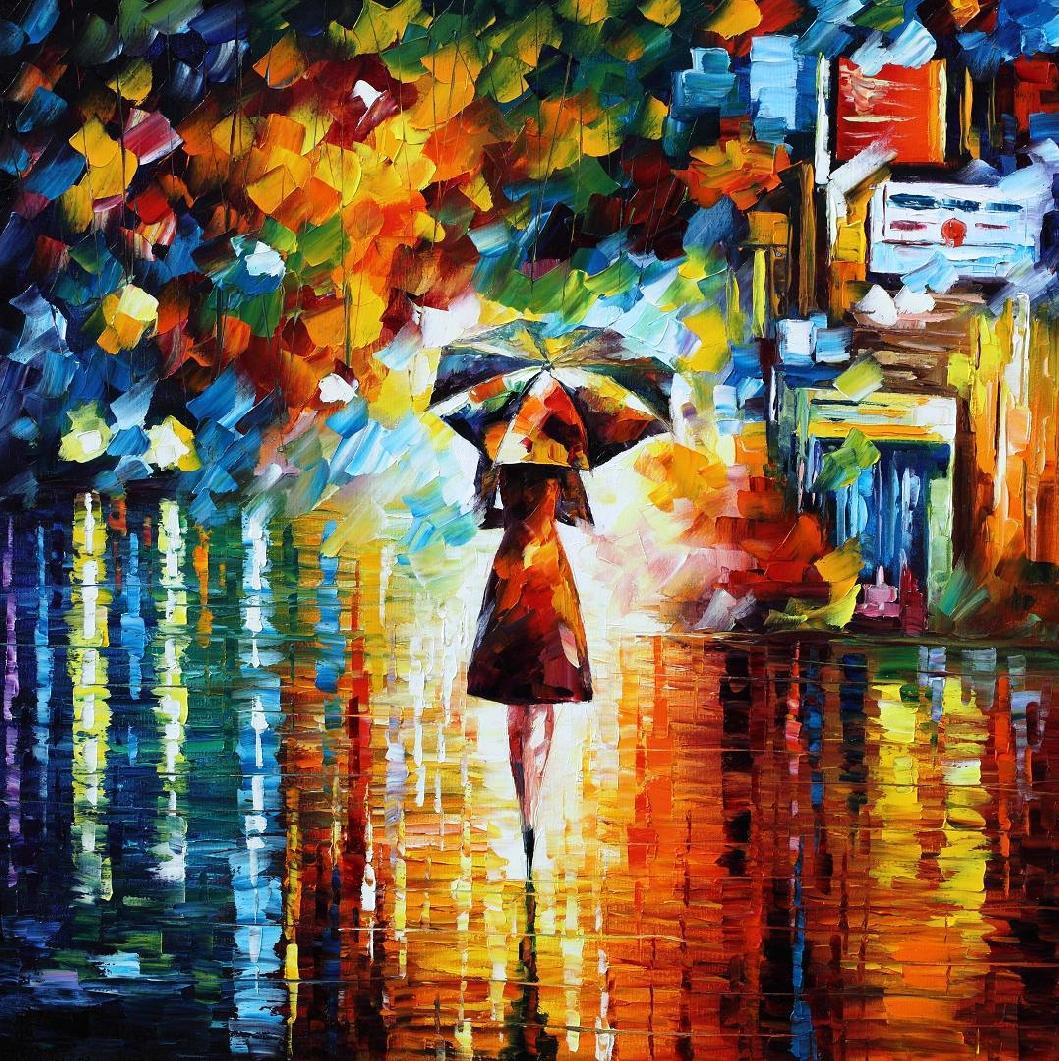

In [40]:
Image.open(style_path)

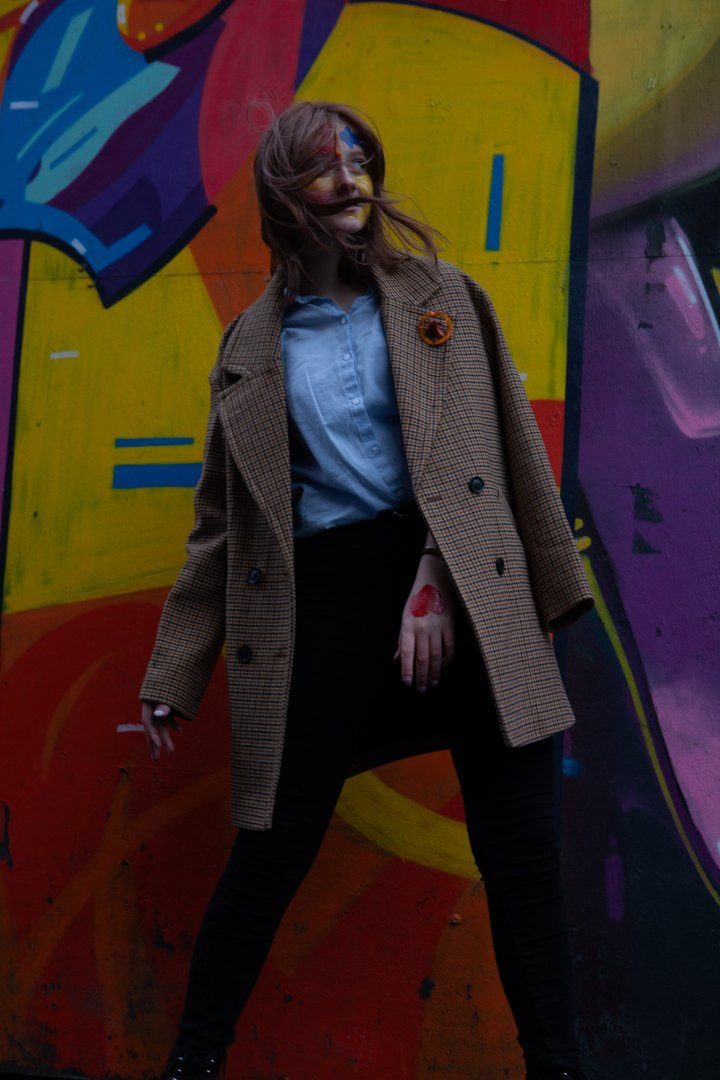

In [41]:
Image.open(image_path)

(720, 1080)


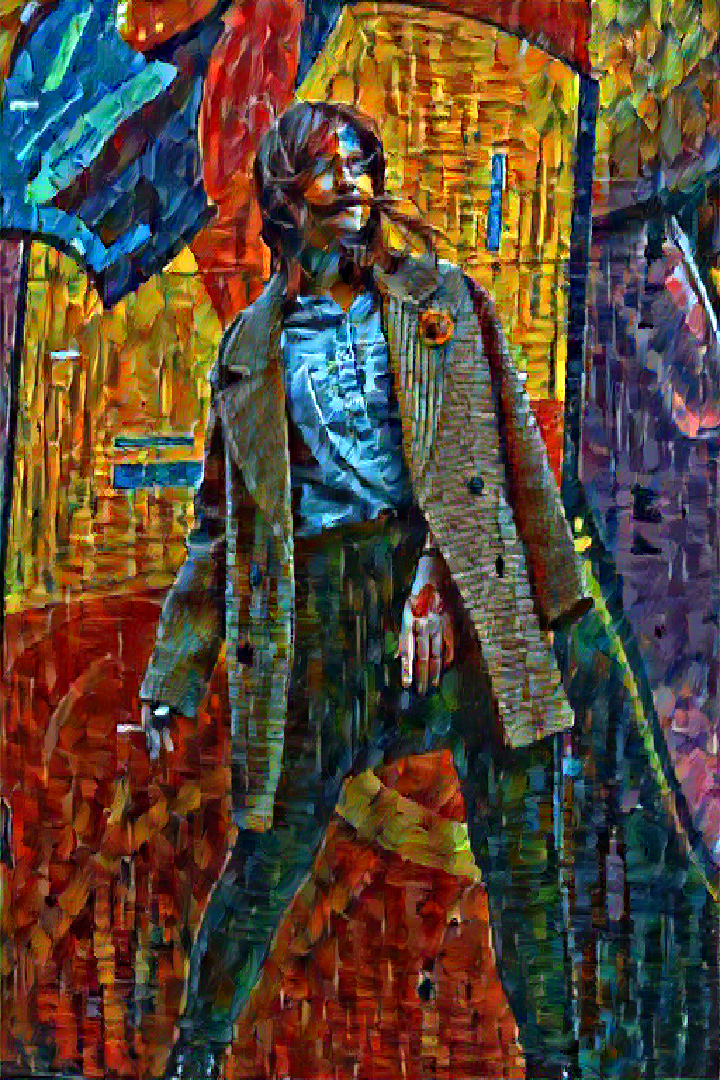

In [42]:
image_size = Image.open(image_path).size
print(image_size)
x_s = load_image(style_path, 512)
x_c = load_image(image_path, 512)

x_o = make_style_transfer(x_s, x_c)

to_image(x_o).resize(image_size)